## Studying Growth Instability

This code lets us explore how QLC-2 solutions vary with the following parameters:
- $\overline N$, and $N^*$ (atomistic-level characteristics of the ice QLL thicknesses)
- $\sigma_o$ (difference in equilibrium supersaturation between microsurfaces I and II)
- $h_{pr}$ (thickness of a prismatic facet monolayer)
- $D_{surf}$ (surface diffusion coefficient of the QLL)
- $\nu_{kin}$ (kinetic velocity -- the rate at which water vapor strikes the surface)
- $L$ (physical length of the facet surface)
- $nx_{crystal}$ (number of discrete points used to represent the surface)
- $L$ (crystal dimension)
- $\sigma_{I,corner}$ (imposed supersaturation at the facet corner)
- $c_r$ (relative reduction in supersaturation at facet centers relative to corners, in fraction and %)
- $\tau_{eq}$ (time constant for ice/QLL freezing/thawing)

In addition, there's the possibility of activating the "microsurface" capablity, by specifying microsurfaces=1. In that case, additional parameters are needed:
- $\sigma_0$ multiplier (how the volatility of the pyramidal facet compares to that of the prismatic (>1 => less volatile)
- $h_{py}$ multiplier (how the thickness of a pyramidal compares to that of the prismatic (>1 => thicker)
- $N^*$ multiplier (how the variability of the pyramidal facet compares to that of the prismatic (>1 => more variable)
- $\theta$ (angle of the additional microfacet with respect to the prismatic (for pyramidal, this is 28 degrees)
- $\beta_{trans}$ multiplier (gradualness of transition between microfacet angles (smaller => more gradual))

These are specified as small departures from a baseline scenario, taken from *Parameter Baseline*, which tries to come up with a self-consistent set of parameters at given values of:
- $T$ (ambient temperature)
- $P$ (ambient air pressure)
- $\sigma_{I,far}$ and $x_{far}$ (super/subsaturation of water vapor far from the crystal, and distance from the crystal at which $\sigma_{I,far}$ is specified)

In [53]:
import numpy as np
import matplotlib.pylab as plt
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
from importlib import reload
from scipy import optimize
from matplotlib import rcParams
from scipy.fft import fft, ifft, rfft, irfft, fftfreq

import sys
sys.path.append('..')
import QLCstuff as QLC

In [54]:
%matplotlib notebook
ticklabelsize = 15
linewidth = 1
fontsize = 15
titlefontsize = 8
color = 'k'
markersize = 10

# Preferred units
distance_unit = 'micrometer'
pressure_unit = 'pascal'
time_unit = 'microsecond'
temperature_unit = 'kelvin'

### Defining parameters for runs

In [55]:
# Properties of the QLL
Nbar = 1.0
print('Nbar', Nbar)
Nstar = 0.1
print('Nstar', Nstar)

# Difference in equilibrium supersaturation between microsurfaces I and II
sigma0 = 0.2
print('sigma0 =',sigma0)

# Thickness of monolayers
h_pr = AssignQuantity(0.389,'nanometer') # Prismatic facet as used in Neshyba et al 2016
print('h_pr', h_pr)
h_pr.ito('micrometer')

# Diffusion coeficient
D = AssignQuantity(3.65e-04,'micrometer^2/microsecond')
print('D',D)

# Kinetic velocity
nu_kin = AssignQuantity(140,'micrometer/second')
print('nu_kin', nu_kin)

# Size of the facet
L = AssignQuantity(30,'micrometer')
print('L', L)

# Crystal size -- needs to be an even number
nx_crystal = 320 
print('nx (crystal)', nx_crystal)

# Supersaturation at the corner of a facet
sigmaI_corner = AssignQuantity(0.22,'dimensionless') 
print('sigmaI_corner', sigmaI_corner)

# Reduction of supersaturation at the facet cental
c_r_percent = AssignQuantity(1,'dimensionless')
print('c_r_percent',c_r_percent)

# Time constant for freezing/thawing
tau_eq = AssignQuantity(5.0,'microsecond')
print('tau_eq',tau_eq)

# Integration algorithm (other possibilities: RK23, DOP853, LSODA, and Radau)
odemethod = 'RK45' # Explicit Runge-Kutta
# odemethod = 'BDF' # Implicit multi-step variable-order (1 to 5) method (takes ~100x explicit methods)

Nbar 1.0
Nstar 0.1
sigma0 = 0.2
h_pr 0.389 nanometer
D 0.000365 micrometer ** 2 / microsecond
nu_kin 140 micrometer / second
L 30 micrometer
nx (crystal) 320
sigmaI_corner 0.22 dimensionless
c_r_percent 1 dimensionless
tau_eq 5.0 microsecond


### Below are microfacet parameters (ignored if microfacets=0)

In [56]:
# Whether to use microfacets (0 => no microfaceting)
microfacets = 0
print('microfacets',microfacets)

# How the volatility of the pyramidal facet compares to that of the prismatic (>1 => less volatile)
sigma0factor = 1.1
print('sigma0factor',sigma0factor)

# How the pyramidal layer thickness compares to the prismatic (>1 => thicker)
h_pyfactor = 1 
print('h_pyfactor',h_pyfactor)

# How the variability of the pyramidal facet compares to that of the prismatic (>1 => more variable)
Nstarfactor = 0.9
print('Nstarfactor',Nstarfactor)

# Angle of the pyramidal facet
theta = AssignQuantity(5, 'degrees')
print('theta',theta)

# Gradualness of transition between prismatic and pyramidal angles (smaller => more gradual)
beta_trans_factor = 10
print('beta_trans_factor',beta_trans_factor)

# Threshold for smoothing out spikes
d2Ntot_dx2_threshold = AssignQuantity(10000,'1/micrometer^2')
print('d2Ntot_dx2_threshold',d2Ntot_dx2_threshold)

microfacets 0
sigma0factor 1.1
h_pyfactor 1
Nstarfactor 0.9
theta 5 degree
beta_trans_factor 10
d2Ntot_dx2_threshold 10000 / micrometer ** 2


### Exploring what happens when the prismatic facet has pyramidal-like properties

In [57]:
Nstar *= Nstarfactor
print('Nstar', Nstar)

sigma0 *= sigma0factor
print('sigma0 =',sigma0)

Nstar 0.09000000000000001
sigma0 = 0.22000000000000003


### Varibles that depend on the above

In [58]:
c_r = c_r_percent/100
x_QLC = np.linspace(-L,L,nx_crystal)
sigmaI_QLC = sigmaI_corner*(c_r*(x_QLC/L)**2+1-c_r)
nu_kin_mlyperus = nu_kin/h_pr
nu_kin_mlyperus.ito('1/microsecond')
deltax = x_QLC[1]-x_QLC[0]
print('Spacing of points on the ice surface =', deltax)
Doverdeltax2 = D/deltax**2

Spacing of points on the ice surface = 0.18808777429467227 micrometer


### Run the scenario

In [59]:
# Specify the length of the run
tlast = AssignQuantity(10,'millisecond') # Use this line to override the estimated time
tlast.ito('microsecond')

# Number of time steps to keep for reporting later
ntimes = 100

# Flag if we want more output
verbose = 2

extending = 0 # If 1, we're padding on to a previous execution of this cell
if extending == 0:
    tkeep_1Darr = np.linspace(0,tlast,ntimes)
    Ntot_init_1D = np.ones(nx_crystal)
    NQLL_init_1D = QLC.getNQLL(Ntot_init_1D,Nstar,Nbar)
else:
    tstart = tkeep_1Darr[-1]
    tstop = tstart + tlast
    tkeep_1Darr = np.linspace(tstart,tstop,ntimes)
    Ntot_init_1D = Ntotkeep_1D[-1,:]
    NQLL_init_1D = NQLLkeep_1D[-1,:]

print('This is a run from time', tkeep_1Darr[0].to('msec'),'to', tkeep_1Darr[-1].to('msec'))
print('dt =', tkeep_1Darr[1]-tkeep_1Darr[0])

# Label for graphs
title_params = \
        "{:.0f}".format(L.magnitude)+' '+str(L.units)+\
        ", "+np.format_float_scientific(D.magnitude,precision=2)+" "+str(D.units)+\
        "\n"+\
        "{:.0f}".format(nu_kin.magnitude)+' '+str(nu_kin.units)+\
        "\n"+\
        "{:.3f}".format(sigmaI_corner.magnitude)+' '+str(sigmaI_corner.units)+\
        ", "+"{:.1f}".format(tau_eq.magnitude)+' '+str(tau_eq.units)+\
        ", "+"{:.3f}".format(c_r_percent.magnitude)+'%'+\
        ", "+odemethod+\
        "\n"
    
# Solve the 1-D problem
Ntotkeep_1D, NQLLkeep_1D = QLC.run_pypr(\
                    NQLL_init_1D, Ntot_init_1D, tkeep_1Darr,\
                    Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq, \
                    theta, beta_trans_factor, Nstarfactor, h_pr, h_pyfactor, sigma0factor,\
                    sigmaI_QLC, x_QLC, d2Ntot_dx2_threshold,
                    AssignQuantity,\
                    verbose, odemethod=odemethod, microfacets=microfacets)
Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D

This is a run from time 0.0 millisecond to 10.0 millisecond
dt = 101.01010101010101 microsecond
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
10 % elapsed time is 0.001 minutes
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
20 % elapsed time is 0.002 minutes
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smooth list is  (0,)
Shape of the smoot

<IPython.core.display.Javascript object>


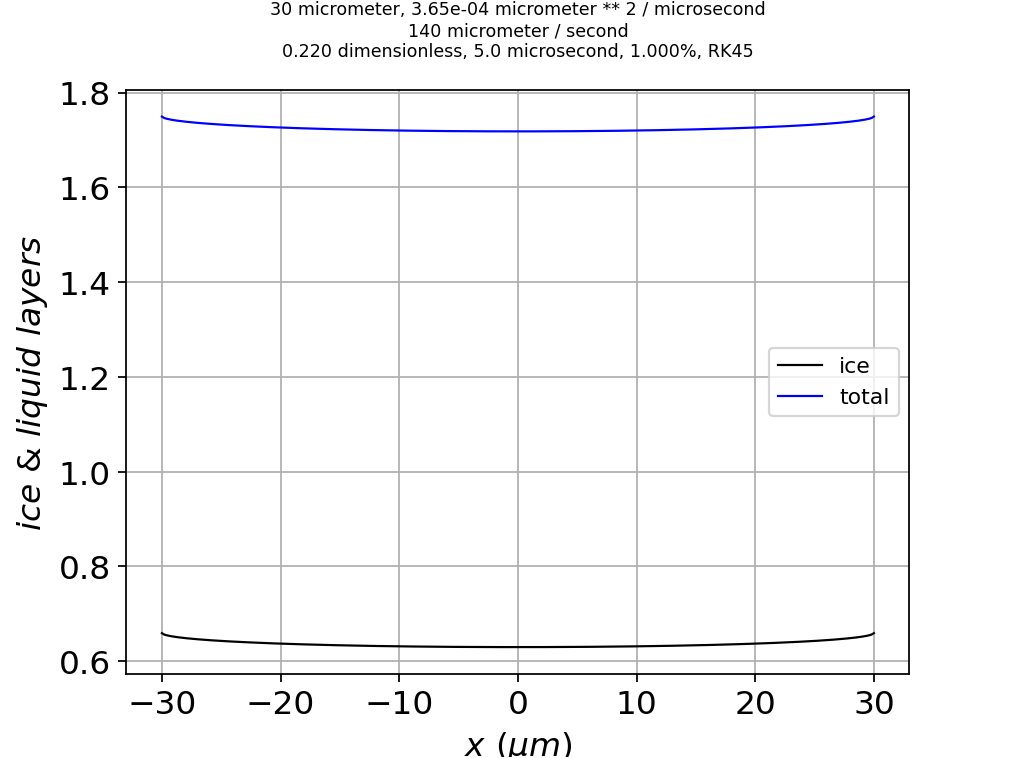

<IPython.core.display.Javascript object>


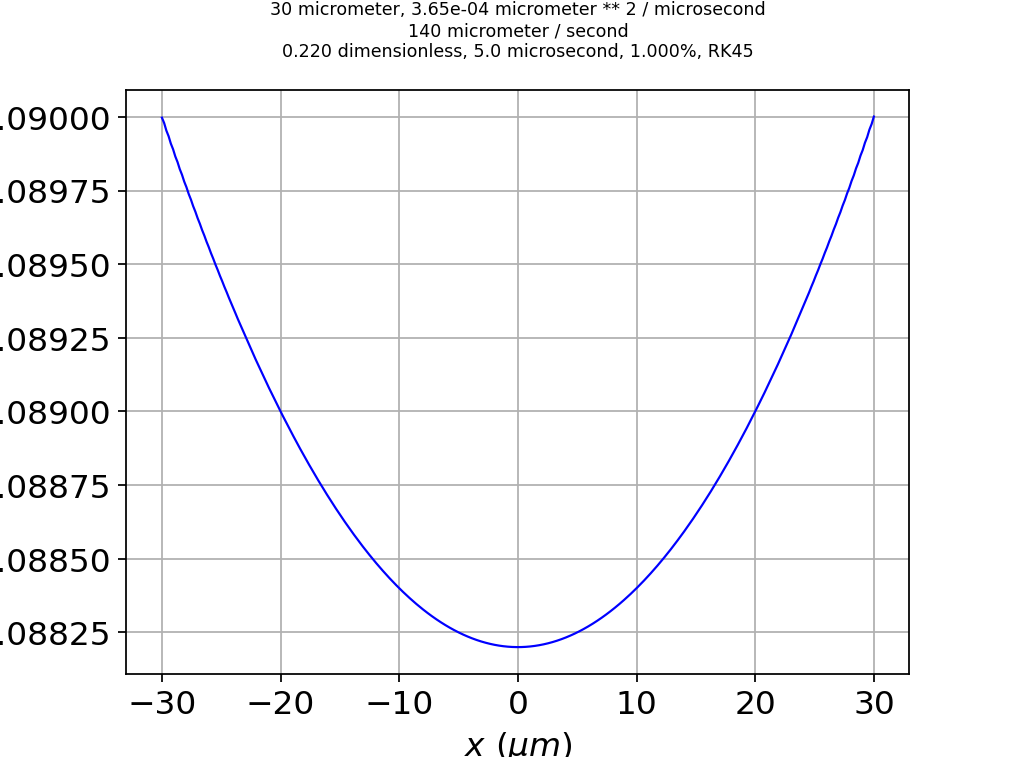

<IPython.core.display.Javascript object>


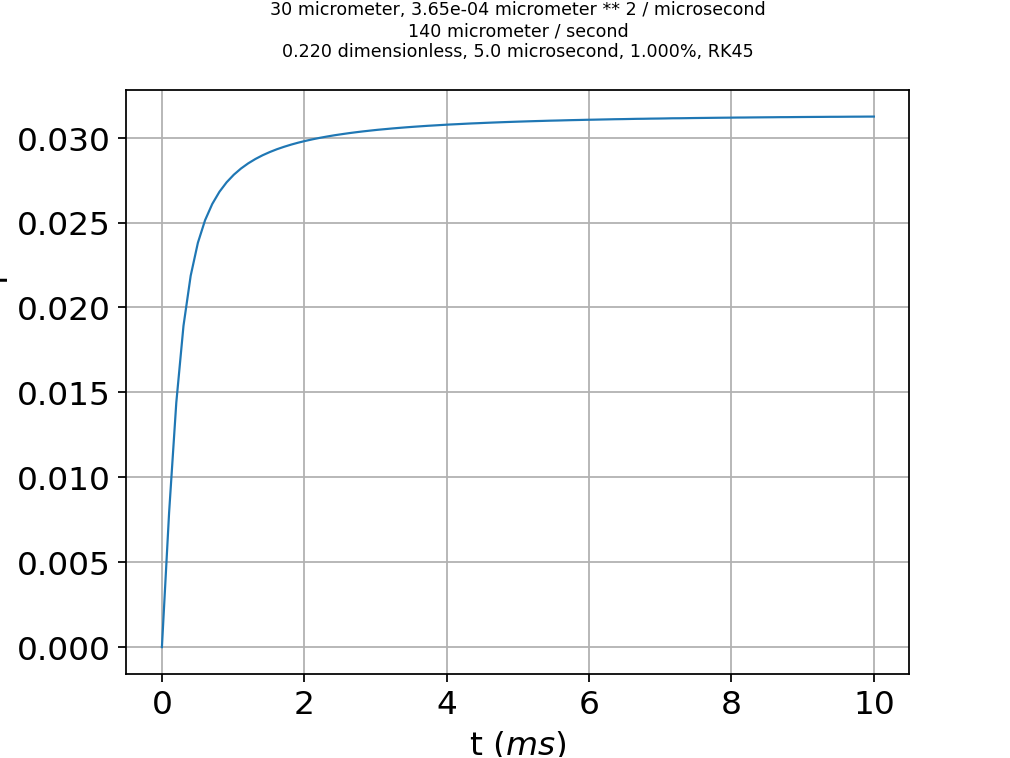

alpha_sticking relative to sigmaI_corner = 4.667528369392398e-07 dimensionless


<IPython.core.display.Javascript object>


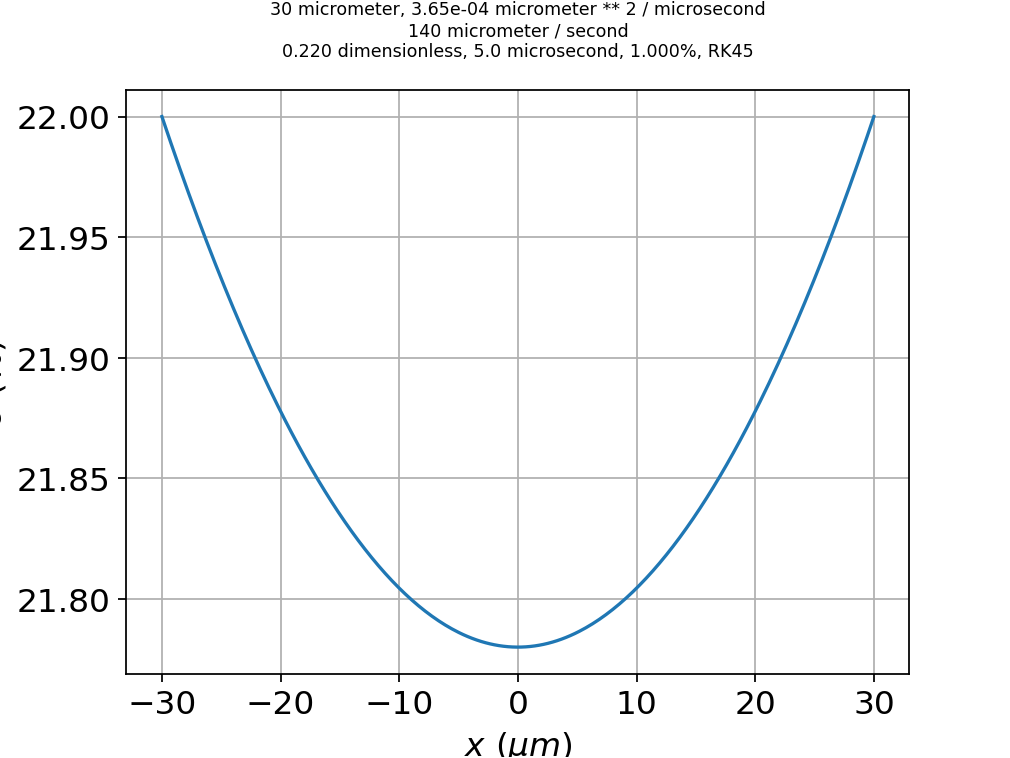

<IPython.core.display.Javascript object>


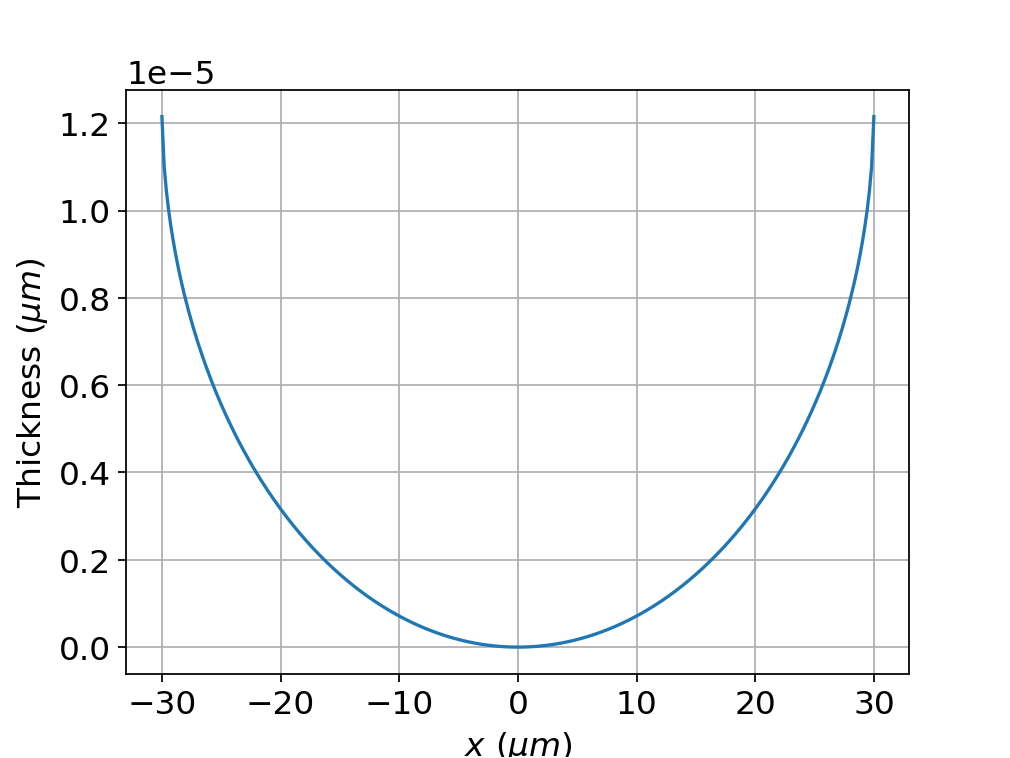

Text(0, 0.5, 'Thickness ($\\mu m)$')

In [60]:
# Reporting and graphing
g_ice_QLC = QLC.report_1d_growth_results(\
        x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,h_pr, \
        graphics=True,title_params=title_params)

# This is only of interest if we're looking at the "sticking" coefficient
alpha_sticking = g_ice_QLC/(sigmaI_corner*nu_kin)
alpha_sticking = AssignQuantity(alpha_sticking,'dimensionless')
print('alpha_sticking relative to sigmaI_corner =',alpha_sticking)

# Additional graphing
plt.figure()
plt.plot(x_QLC.magnitude,sigmaI_QLC.magnitude*100)
plt.grid(True)
plt.xlabel('$x \ (\mu m)$',fontsize=fontsize)
plt.ylabel('$\sigma \ (\%)$',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.title(title_params,fontsize=titlefontsize)

# Ntot in micrometers (instead of layers)
plt.figure()
ydiff = Ntotkeep_1D[-1,:]*h_pr
ydiff = ydiff - np.min(ydiff)
plt.plot(x_QLC.magnitude,ydiff.magnitude)
plt.grid(True)
plt.xlabel('$x \ (\mu m)$',fontsize=fontsize)
plt.ylabel('Thickness ($\mu m)$',fontsize=fontsize)

# # Check out symmetry
# itime = -1
# thisNQLL = NQLLkeep_1D[itime,:]
# thisNQLL_flipped = np.flip(thisNQLL)
# plt.figure()
# plt.plot(x_QLC.magnitude,(thisNQLL_flipped-thisNQLL))
# plt.xlabel('$x \ (\mu m)$',fontsize=fontsize)
# plt.grid(True)
# plt.title('QLL symmetry check',fontsize=titlefontsize)

<IPython.core.display.Javascript object>


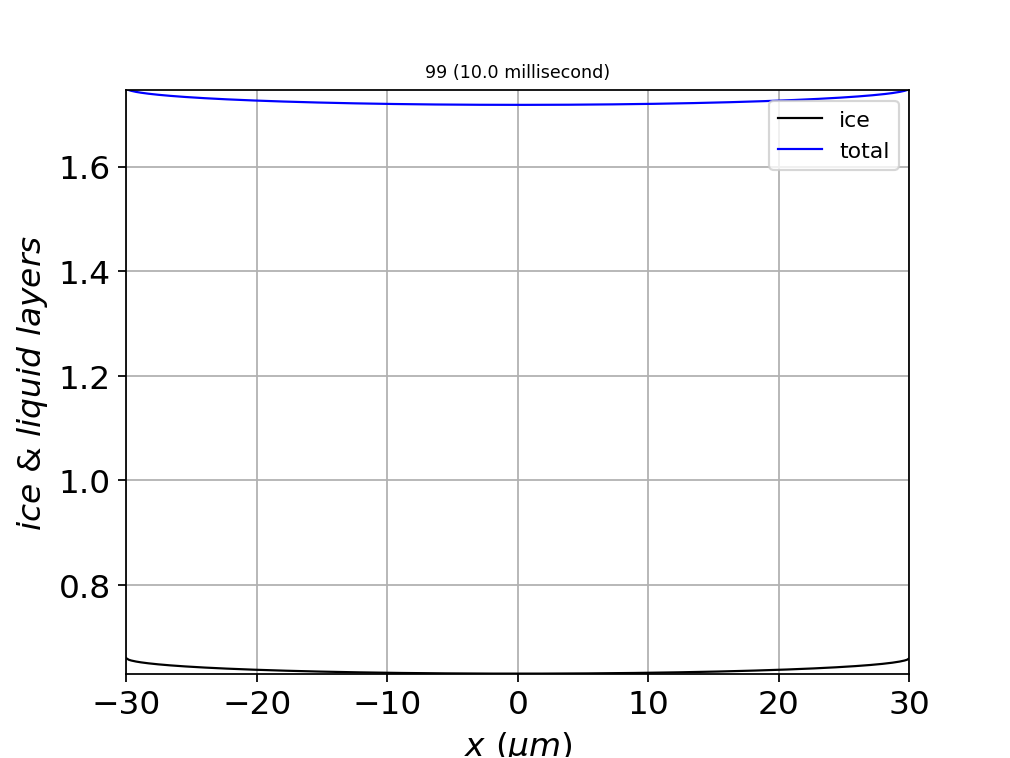

<IPython.core.display.Javascript object>


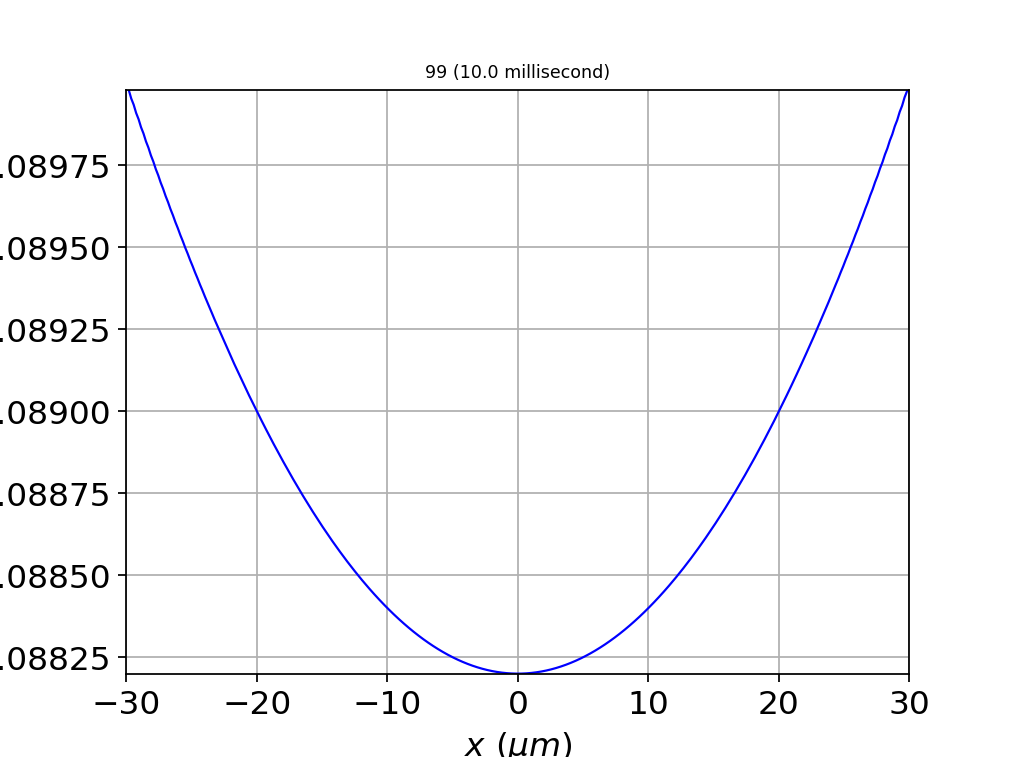

<IPython.core.display.Javascript object>


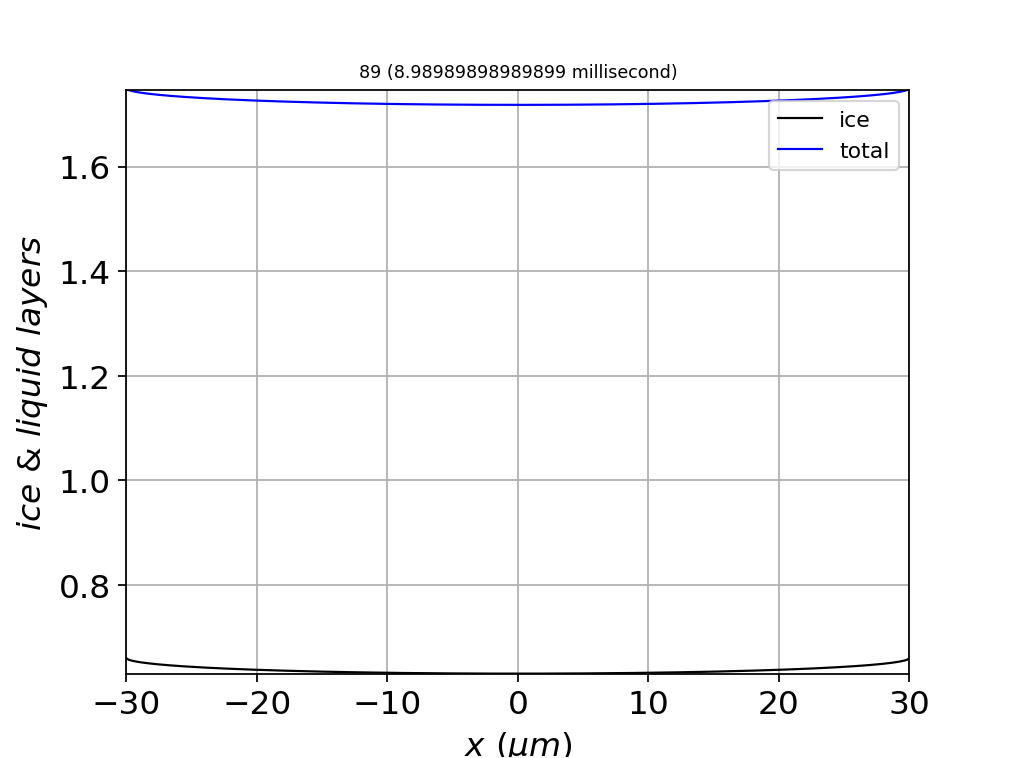

<IPython.core.display.Javascript object>


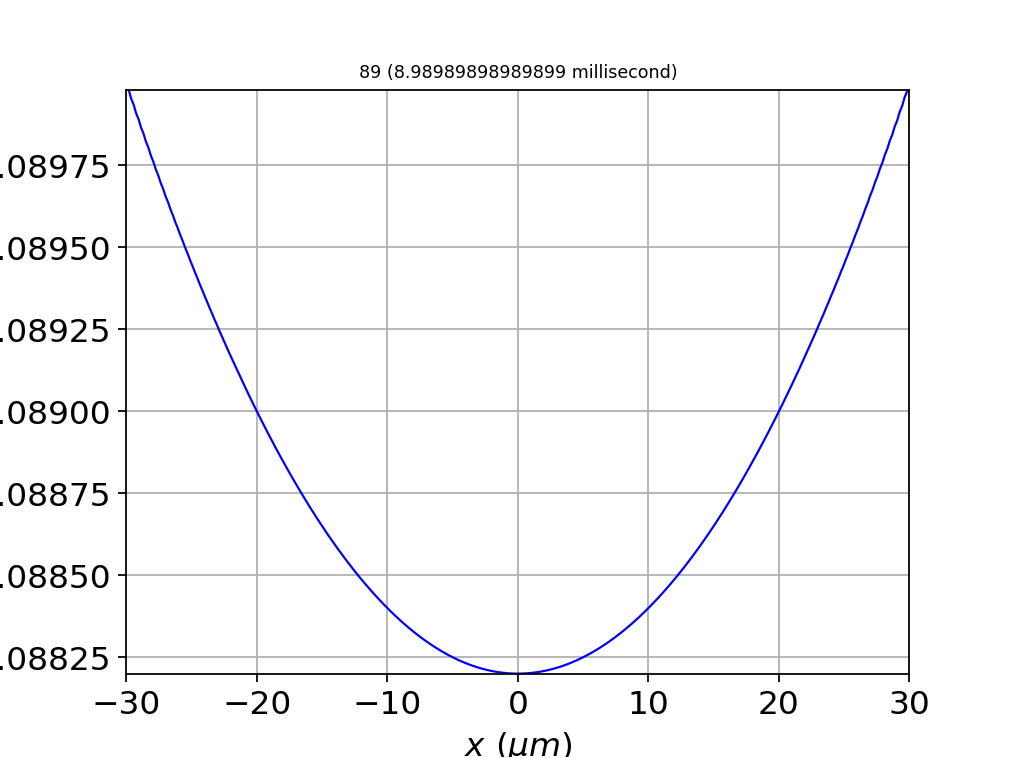

<IPython.core.display.Javascript object>


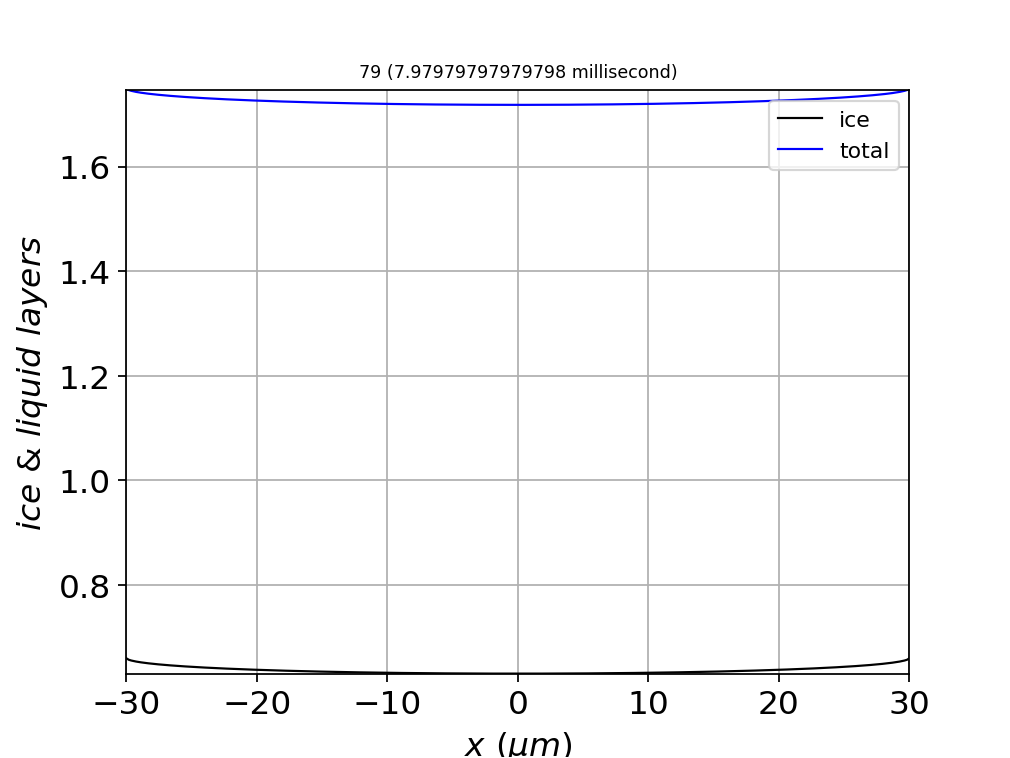

<IPython.core.display.Javascript object>


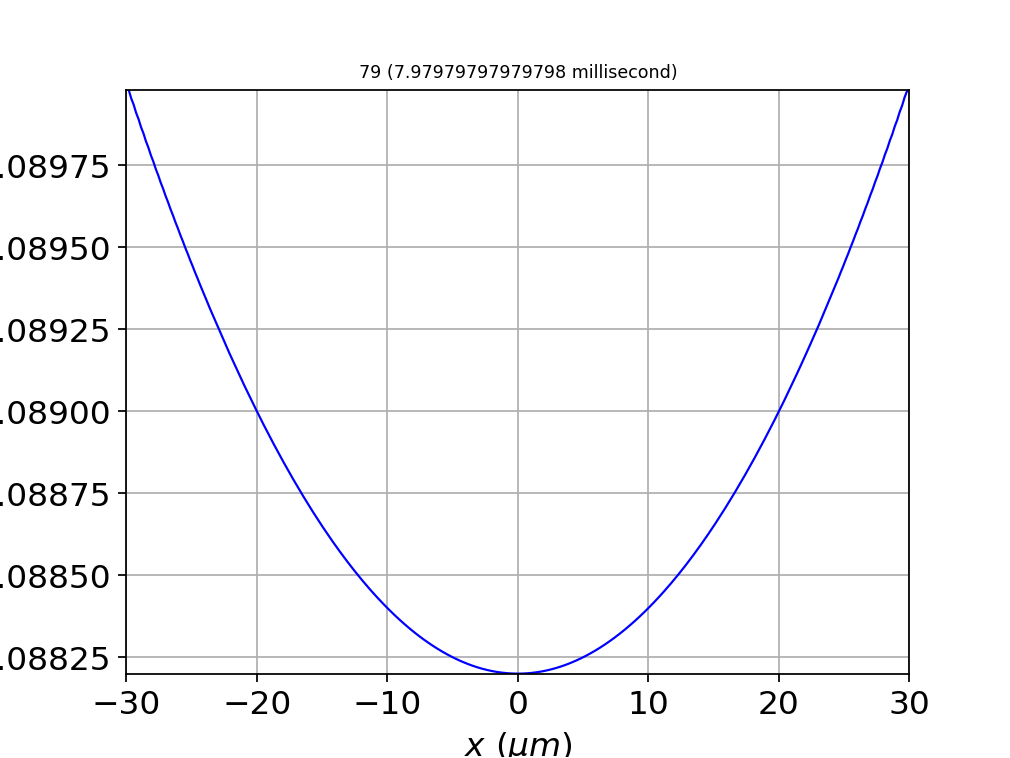

<IPython.core.display.Javascript object>


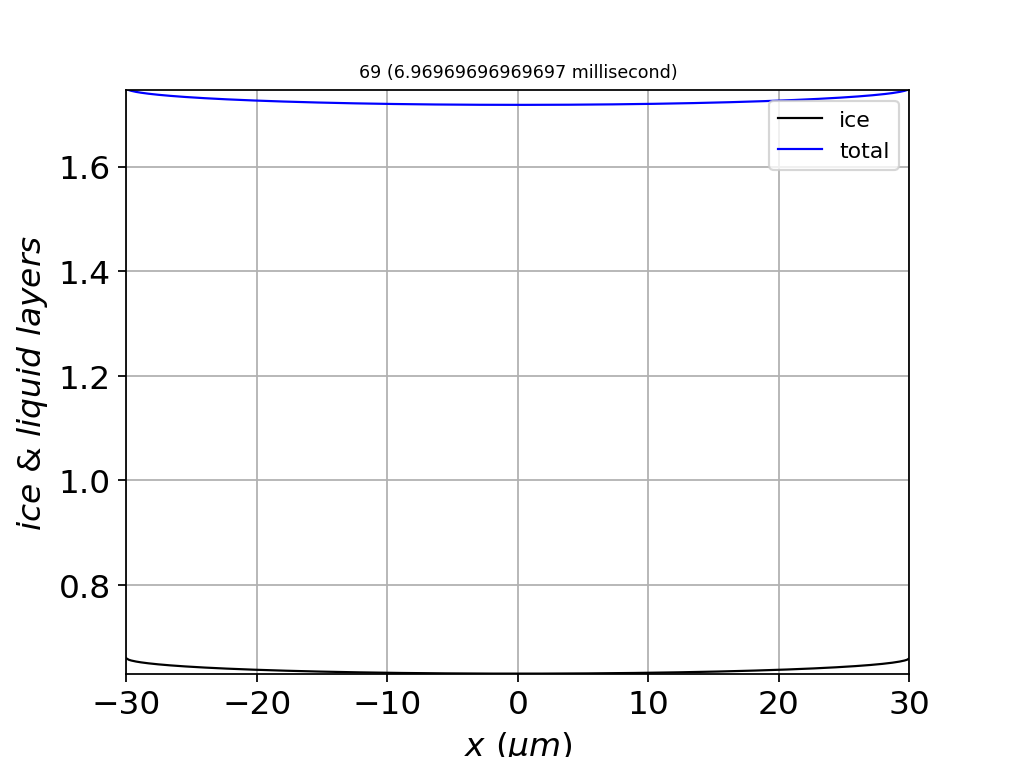

<IPython.core.display.Javascript object>


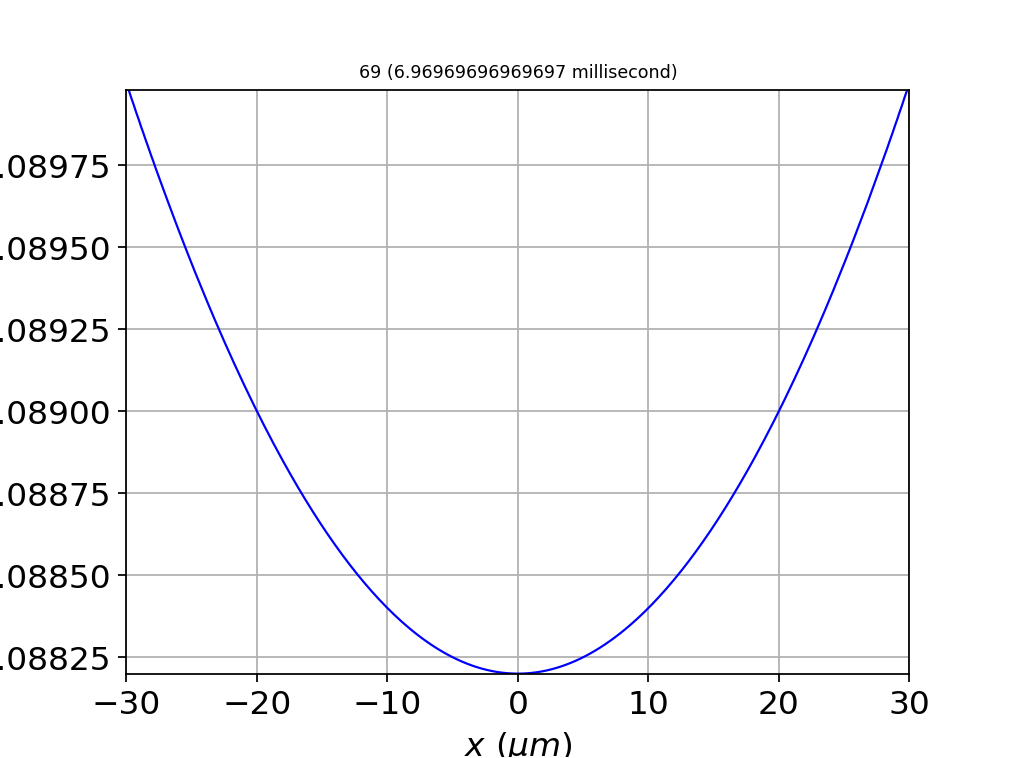

<IPython.core.display.Javascript object>


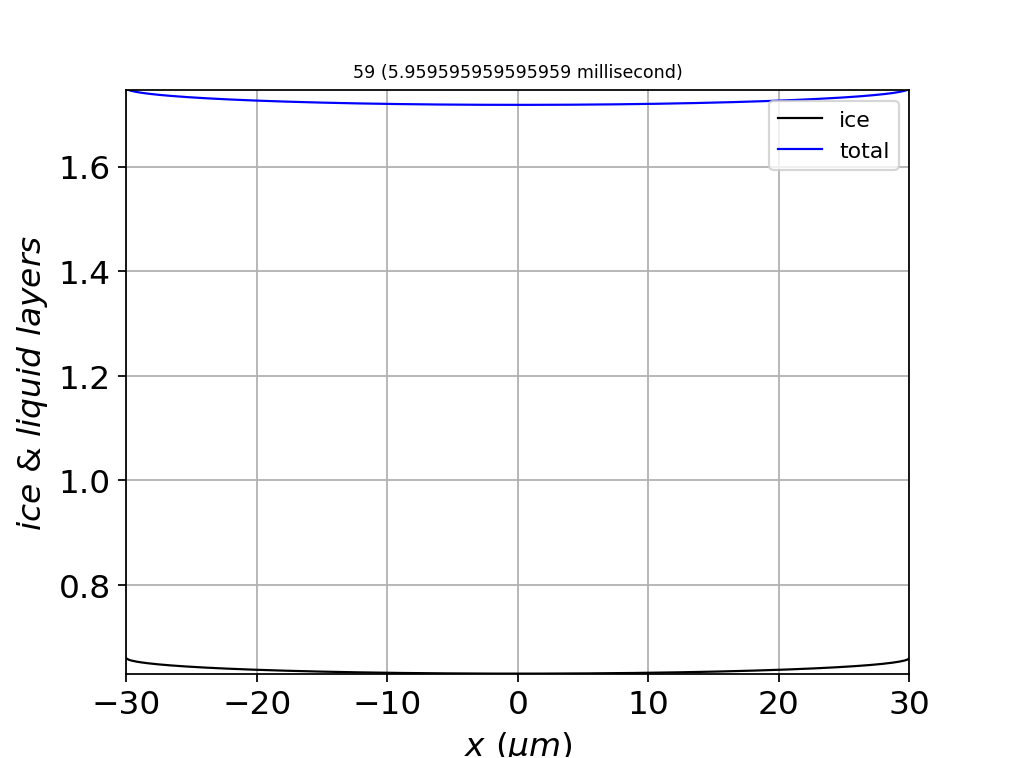

<IPython.core.display.Javascript object>


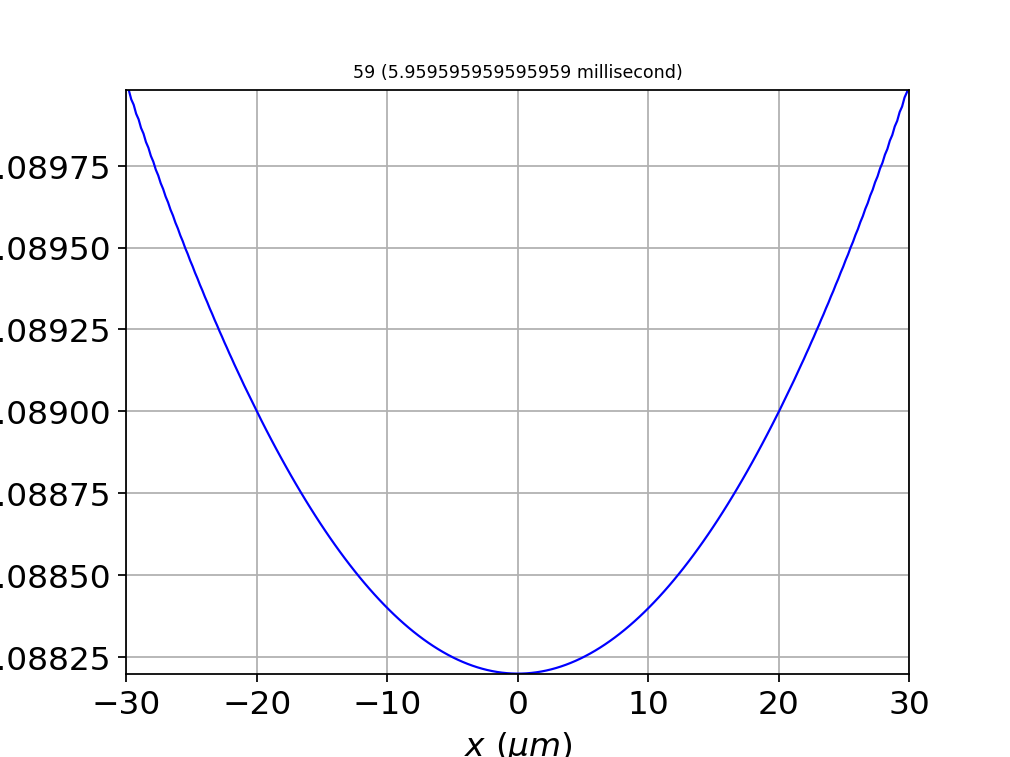

<IPython.core.display.Javascript object>


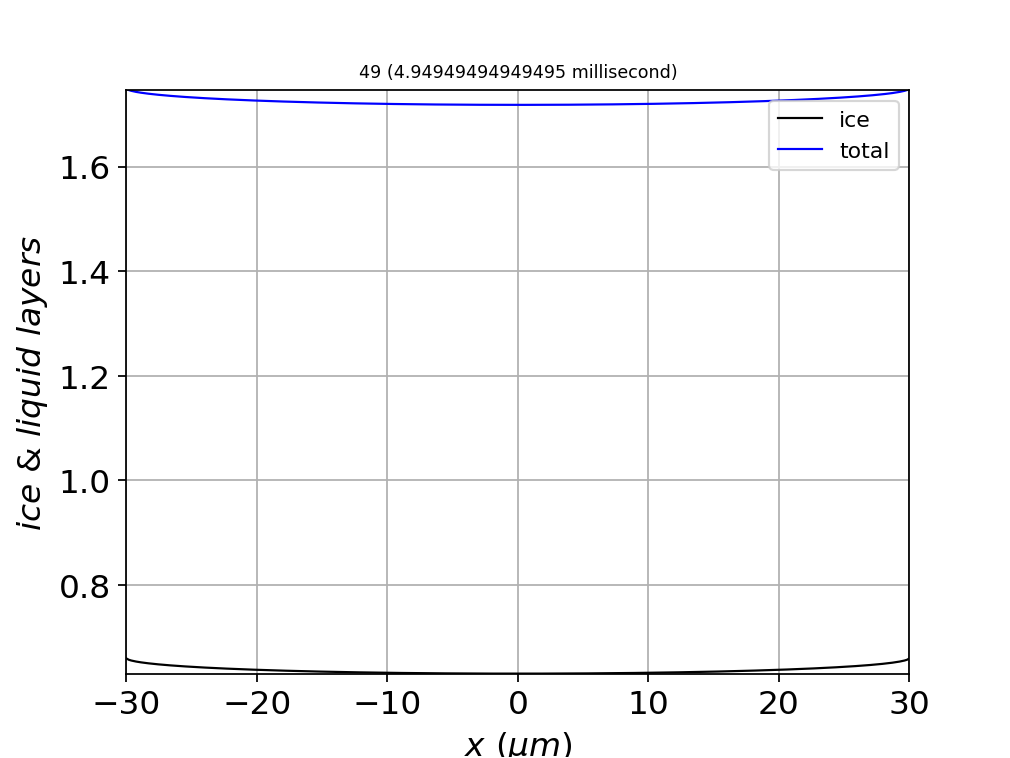

<IPython.core.display.Javascript object>


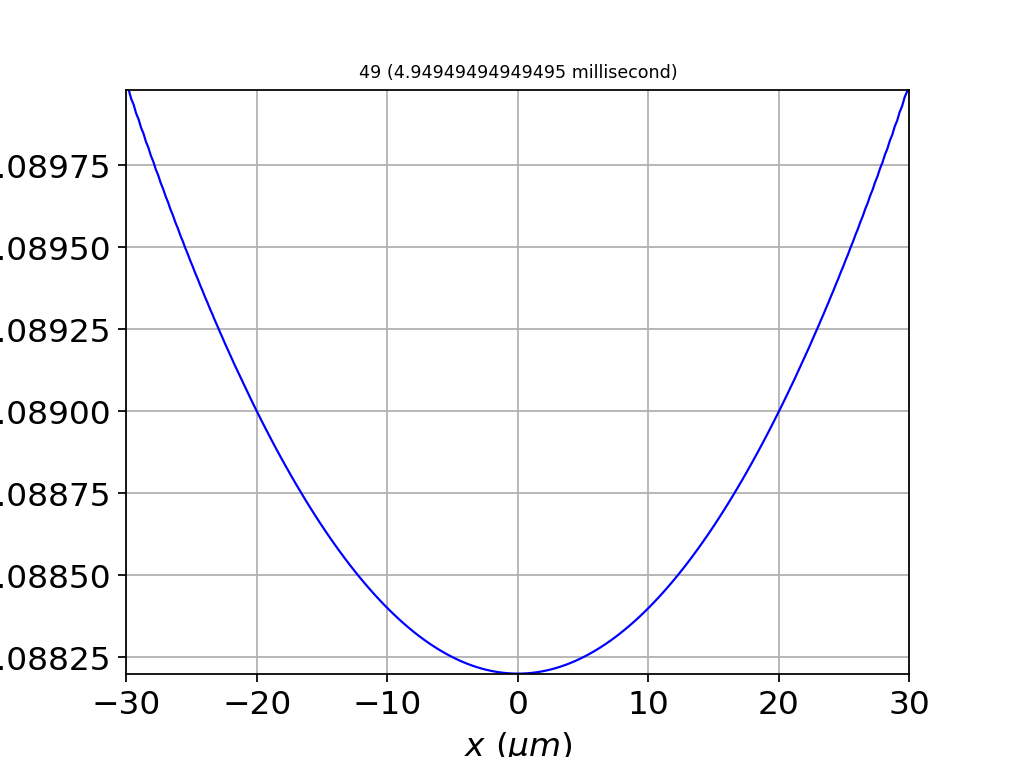

<IPython.core.display.Javascript object>


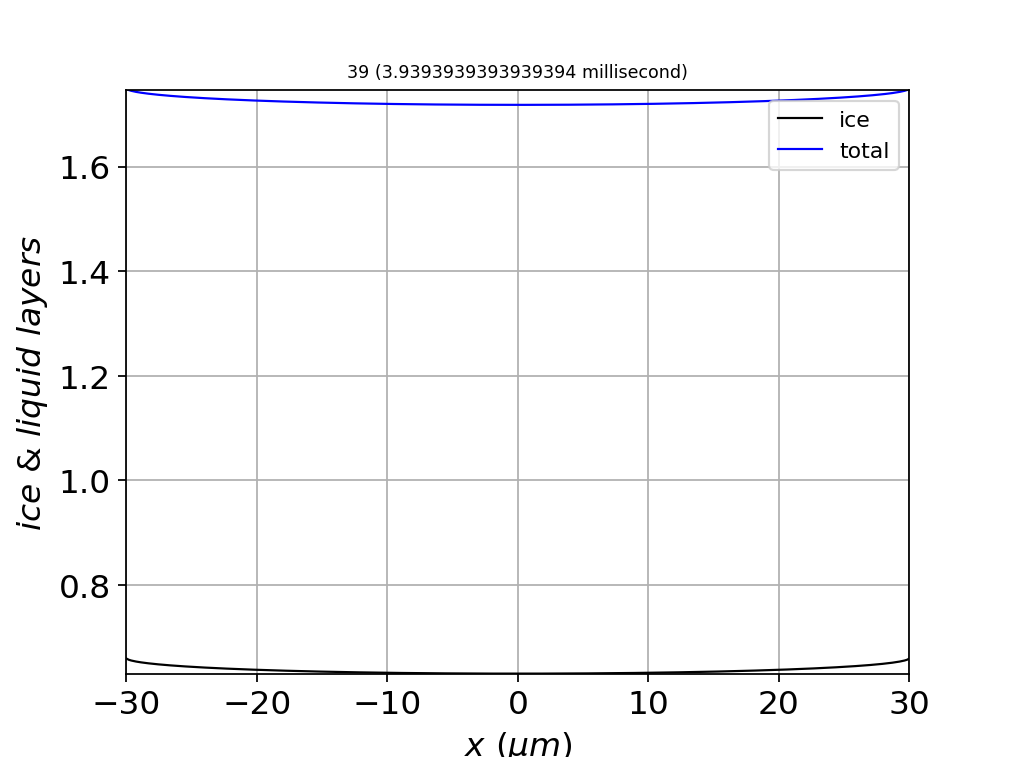

<IPython.core.display.Javascript object>


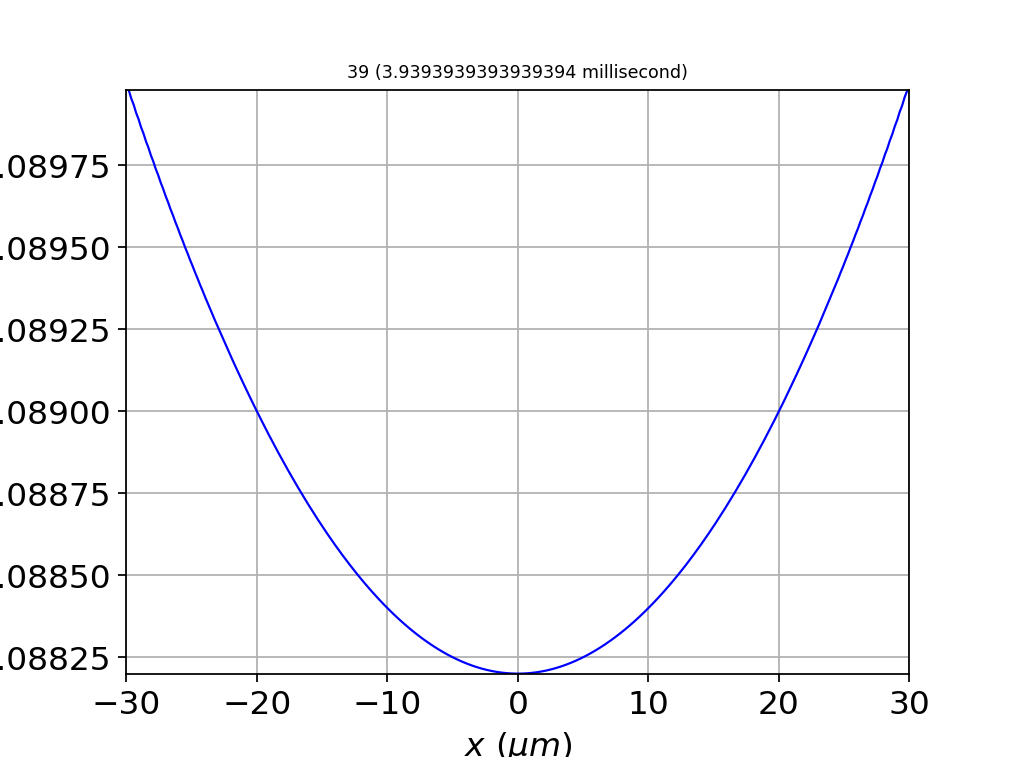

<IPython.core.display.Javascript object>


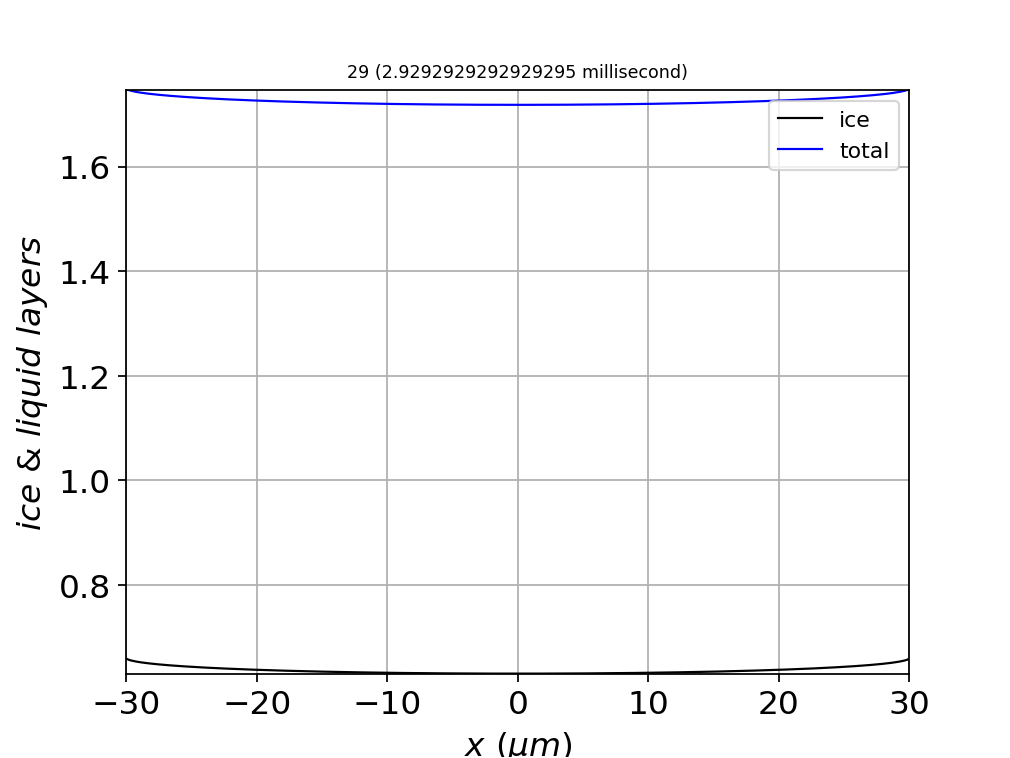

<IPython.core.display.Javascript object>


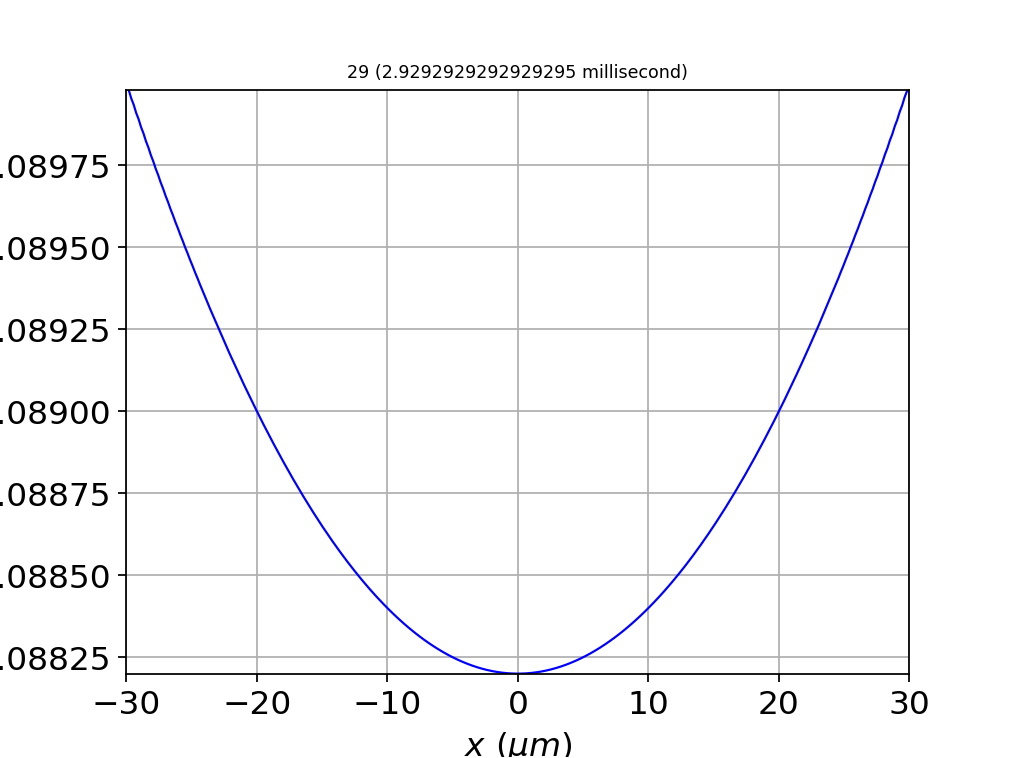

<IPython.core.display.Javascript object>


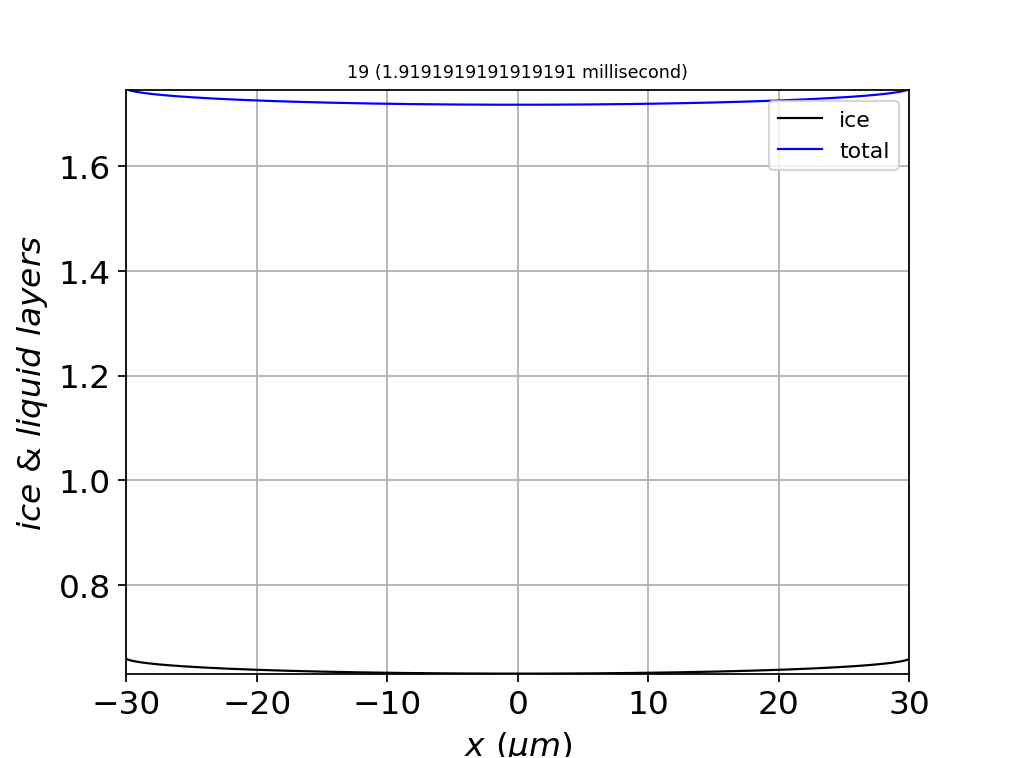

<IPython.core.display.Javascript object>


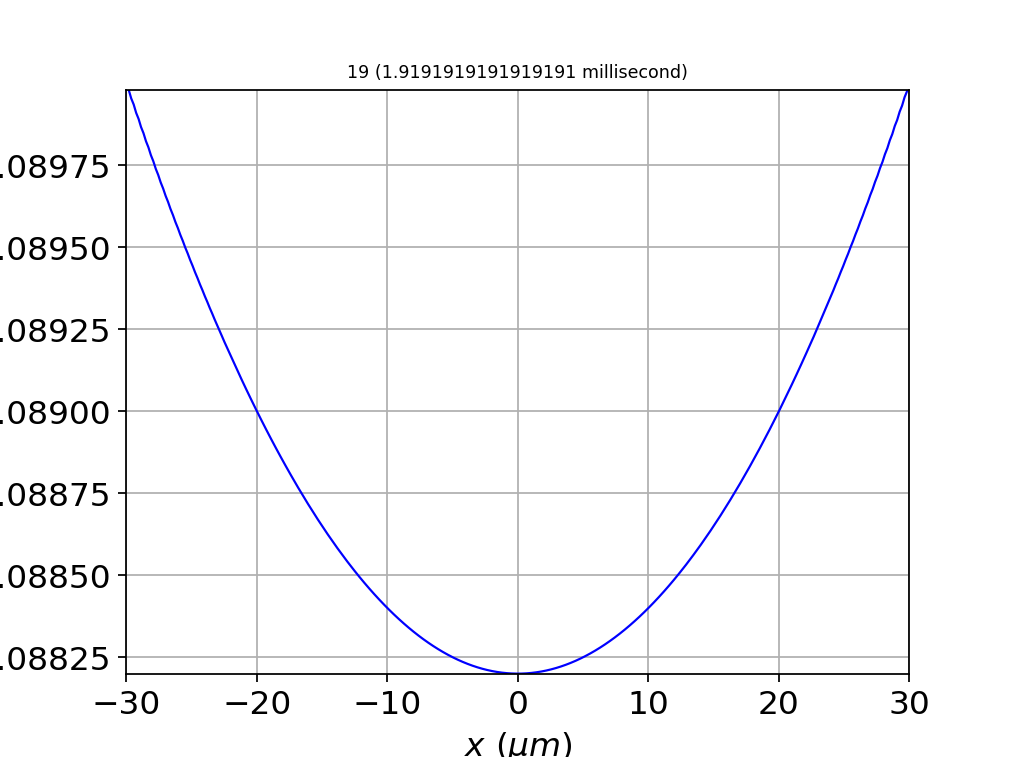

<IPython.core.display.Javascript object>


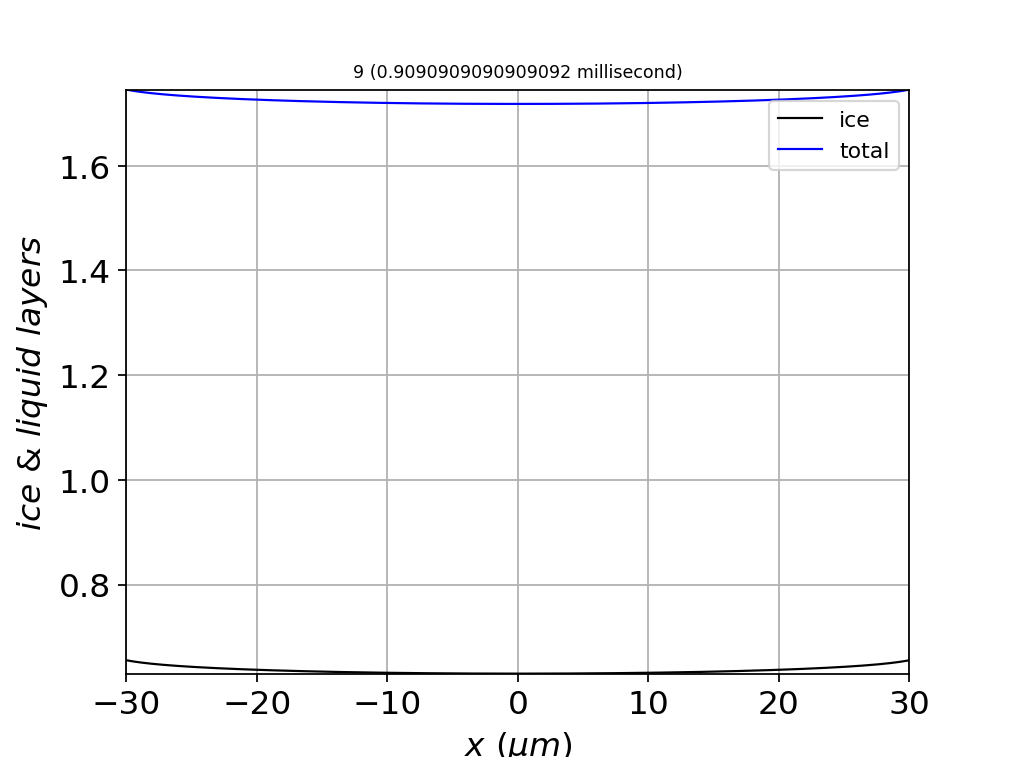

<IPython.core.display.Javascript object>


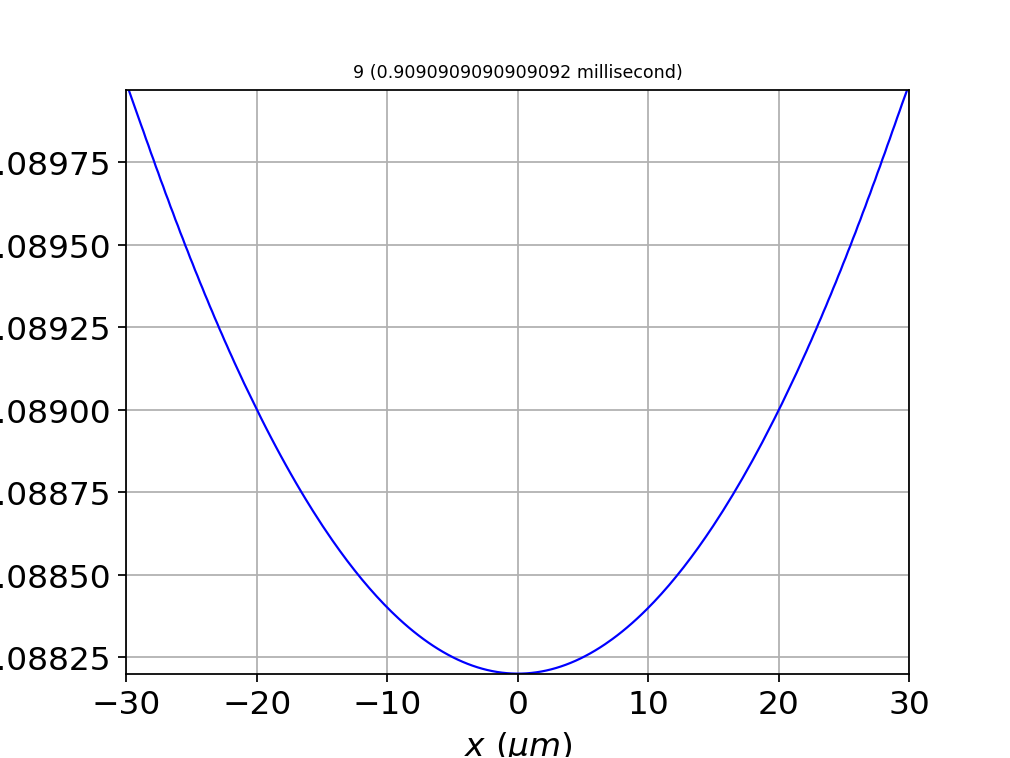

In [61]:
# Check out intermediate values
for itime in range(ntimes-1,0,-10):
    title_params = str(itime)+' ('+str(tkeep_1Darr[itime].to('millisecond'))+')'
    g_ice_QLC = QLC.report_1d_growth_results(\
        x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,h_pr, \
        graphics=True,tgraphics=False,title_params=title_params,itime=itime, \
        xlim=[-30,30])

In [62]:
# Probing properties of multiple facet types
if microfacets == 1:
    itime = -1
    print('Probing itime =',itime)
    print('Probing time =',tkeep_1Darr[itime].to('millisecond'))
    Ntot_pr = Ntotkeep_1D[itime,:]
    NQLL_pr = NQLLkeep_1D[itime,:]
    xleft = -L.magnitude
    xright = L.magnitude
    
    # Checking out the smoothness algorithm
    d2Ntot_dx2, Ntot_pr_smoothed = QLC.smoothout(\
            x_QLC.magnitude,Ntot_pr,deltax.magnitude,d2Ntot_dx2_threshold.magnitude,verbose=2)                                      
    plt.figure()
    plt.plot(x_QLC,d2Ntot_dx2)
    plt.grid(True)
    plt.ylabel(r'$d^2N_{tot}/dx^2$')
    plt.xlim([xleft,xright])
    plt.figure()
    plt.plot(x_QLC,Ntot_pr,'-+',label='orig')
    plt.plot(x_QLC,Ntot_pr_smoothed,label='smoothed')
    plt.ylabel(r'$N_{tot}$')
    plt.legend()
    plt.xlim([xleft,xright])
    
    # Specifying how to partition among the three facets
    print('Parameters for partition among the three facets')
    beta_trans = np.sin(theta/2)/np.cos(theta/2)
    print('beta_trans =', beta_trans)
    delta_beta = beta_trans/beta_trans_factor
    print('delta_beta',delta_beta)

    # Visualizing Ntot of the various faceting frames
    h_py = h_pr*h_pyfactor
    Ntot_pyneg = 1/h_py * (np.cos(theta)*h_pr* Ntot_pr -np.sin(theta)*x_QLC)
    Ntot_pypos = 1/h_py * (np.cos(theta)*h_pr* Ntot_pr +np.sin(theta)*x_QLC)
    plt.figure()
    plt.plot(x_QLC,Ntot_pr,label='prismatic')
    # plt.plot(x_QLC,Ntot_pyneg,label='negative-sloped '+str(theta))
    # plt.plot(x_QLC,Ntot_pypos,label='positive-sloped '+str(theta))
    plt.xlabel('x',fontsize=fontsize)
    plt.ylabel('Ntot',fontsize=fontsize)
    plt.grid(True)
    plt.legend()
    plt.xlim([xleft,xright])

    # Checking out the algorithm for calculating microfacet weights
    z_pr = h_pr * Ntot_pr
    dx = x_QLC[1]-x_QLC[0]
    beta = np.gradient(z_pr,dx)
    beta.ito('dimensionless')
    alpha_pyneg = QLC.get_alpha(beta.magnitude,-beta_trans.magnitude,delta_beta.magnitude)
    alpha_pypos = 1-QLC.get_alpha(beta.magnitude, beta_trans.magnitude,delta_beta.magnitude)
    alpha_pr = 1 - alpha_pyneg - alpha_pypos
    plt.figure()
    plt.plot(x_QLC,alpha_pr,label='prismatic')
    plt.plot(x_QLC,alpha_pyneg,label='negative-sloped '+str(theta.to('degree')))
    plt.plot(x_QLC,alpha_pypos,label='positive-sloped '+str(theta.to('degree')))
    plt.xlabel('x',fontsize=fontsize)
    plt.ylabel(r'$\alpha$',fontsize=fontsize)
    plt.legend()
    plt.grid(True)
    plt.xlim([xleft,xright])

    # Checking out the algorithm for calculating the weighted NQLL_eq
    Nstar_pr = Nstar
    Nstar_py = Nstar_pr*Nstarfactor; print(Nstar_py)
    NQLL_eq_pr    = Nbar - Nstar_pr*np.sin(2*np.pi*Ntot_pr)
    NQLL_eq_pyneg = Nbar - Nstar_py*np.sin(2*np.pi*Ntot_pyneg)
    NQLL_eq_pypos = Nbar - Nstar_py*np.sin(2*np.pi*Ntot_pypos)
    NQLL_eq = alpha_pr*NQLL_eq_pr + alpha_pyneg*NQLL_eq_pyneg + alpha_pypos*NQLL_eq_pypos
    plt.figure()
    plt.plot(x_QLC,NQLL_eq_pr,label='prismatic')
    # plt.plot(x_QLC,NQLL_eq_pyneg,label='negative-sloped '+str(theta))
    # plt.plot(x_QLC,NQLL_eq_pypos,label='positive-sloped '+str(theta))
    plt.plot(x_QLC,NQLL_eq,label='combined')
    plt.xlabel('x',fontsize=fontsize)
    plt.ylabel('NQLL(eq)',fontsize=fontsize)
    plt.legend()
    plt.grid(True)
    plt.xlim([xleft,xright])

    # Algorithm for calculating angles from slopes
    slopes = np.ones(len(x_QLC)) + 1j*beta.magnitude
    angles = AssignQuantity(np.angle(slopes),'radian')
    angles.ito('degree')
    angles_from_atan = np.arctan(beta.magnitude)*180/np.pi
    if np.max(np.abs(angles.magnitude)) < 0.1:
        common_factor = 1000
        extra_label = ' x '+str(common_factor)
    else:
        common_factor = 1
        extra_label = ''
    plt.figure()
    plt.plot(x_QLC,angles.magnitude,label='complex algorithm'+extra_label)
    plt.plot(x_QLC,angles_from_atan,'+',label='arctan algorithm'+extra_label)
    plt.xlabel('x',fontsize=fontsize)
    plt.ylabel(r'pixel $\theta$ ('+str(angles.units)+')',fontsize=fontsize)
    plt.grid(True)
    plt.xlim([xleft,xright])
    plt.legend()
    
    # The delta-corrected diffusion coefficient (multiplying by a common factor so it has units of um^2/us)
    factor_for_display = deltax**2*1000
    Doverdeltax2_array = Doverdeltax2.magnitude*np.ones(len(x_QLC))
    Doverdeltay2_array = Doverdeltax2*np.cos(angles)**2 # Corrected
    plt.figure()
    plt.plot(x_QLC,Doverdeltax2_array*factor_for_display,label='Dx1000')
    plt.plot(x_QLC,Doverdeltay2_array*factor_for_display,label='delta-corrected Dx1000')
    plt.grid(True)
    plt.xlim([xleft,xright])
    plt.legend()